In [1]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import sys
import re
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import random

data = pd.read_csv('fer2013/fer2013.csv')

In [2]:
print(len(data))
print(len(data.loc[0, 'pixels'].split(' ')))
print(data.groupby('Usage').count()[['emotions']])
data.head()

35887
2304
             emotions
Usage                
PrivateTest      3589
PublicTest       3589
Training        28709


,emotions,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
#Frequency of each label
print('0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral')
table = data.groupby('emotions').count()[['Usage']]
table['Pct'] = table['Usage']/table['Usage'].sum()
table['Pct'] = table['Pct'].map(lambda x: round(x, 3)*100)
table

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral


,Usage,Pct
emotions,,
0,4953,13.8
1,547,1.5
2,5121,14.3
3,8989,25.0
4,6077,16.9
5,4002,11.2
6,6198,17.3


## 1) Converting to numpy datasets

In [4]:
def convert_to_numpy(data):
    X = data[:,1]
    X = np.asarray([np.asarray(X[i].split(" ")) for i in range(X.shape[0])])
    X = np.asarray([X[i].reshape(48,48).astype(int) for i in range(X.shape[0])])
    y = data[:,0]
    return (X,y)

In [5]:
train = data[data['Usage'] == 'Training']
train_X, train_Y = convert_to_numpy(train.values)
valid = data[data['Usage'] == 'PrivateTest']
valid_X, valid_Y = convert_to_numpy(valid.values)
test = data[data['Usage'] == 'PublicTest']
test_X, test_Y = convert_to_numpy(test.values)

## 1.1) Viewing image

#### Q.) how should the pixel values be resized????

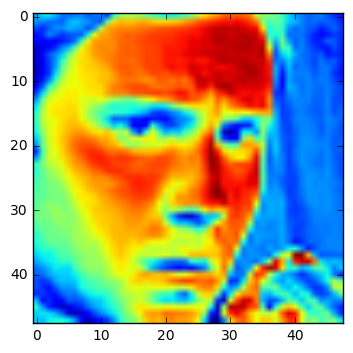

In [6]:
pixel = train_X[0].reshape(48,48).astype(int)
plt.imshow(pixel)
plt.show()

## 2) Function to extract the batches from the dataset

In [7]:
def data_iter(x, y, batch_size):
    dataset_size = x.shape[0]
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while True:
        start += batch_size
        if start > dataset_size - batch_size:
            break   
        batch_indices = order[start:start + batch_size]
        yield np.asarray([x[index] for index in batch_indices]) ,np.asarray([y[index] for index in batch_indices])

## 3) Model 

## CNN Implementation

In [14]:
class CNN(nn.Module):
    """
    CNN model
    """
       
    def __init__(self, kernel_size, num_labels, n_layers=1, dropout=0.1):
       
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(CNN,self).__init__()

        self.conv1 = nn.Sequential(
                            nn.Conv2d(1, 10, kernel_size=kernel_size, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            )
        self.conv2 = nn.Sequential(
                            nn.Conv2d(10, 20, kernel_size=kernel_size, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            )
        self.out = nn.Linear(20*12*12, num_labels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # Note that normally ppl dont use dropout in CNN
        x = self.out(x)
        return torch.nn.functional.softmax(x)

## 4) Training stage setup

In [15]:
def early_stop(val_acc_history, t=2, required_progress=0.001):    
    cnt = 0 # initialize the count --> to store count of cases where difference in
                                    #  accuracy is less than required progress.
    
    if(len(val_acc_history) > 0): # if list has size > 0 
        for i in range(t): # start the loop
            index = len(val_acc_history) - (i+1) # start from the last term in list and move to the left
            if (index >= 1): # to check if index != 0 --> else we can't compare to previous value
                if (abs(val_acc_history[index] - val_acc_history[index-1]) < required_progress):
                    cnt += 1 # increase the count value
                else:
                    break # break if difference is grea-ter 
    
    if(cnt != t): # if count is equal to t, return True
        return False
    else:
        return True
    

def train(train_X, train_Y, valid_X, valid_Y, optimizer, model, batch_size, num_epochs):
    losses = []
    total_batches = int(train_X.shape[0]/ batch_size)
    validation_losses = []
    
    eval_every = 10
    print_every = 10
    validate_every = int((eval_every/100)*total_batches)
    show_every = int((print_every/100)*total_batches)
    
    for epoch in range(1, num_epochs+1):
        stop_training = False
        train_data = data_iter(train_X, train_Y, batch_size)
        for i, (x,y) in enumerate(train_data):
            x = Variable(torch.from_numpy(x).type(torch.FloatTensor))
            y = Variable(torch.from_numpy(y).type(torch.LongTensor))
            model.train(True)
            optimizer.zero_grad()
            #print(x)
            outputs = model(x)
            loss = criterion(outputs, y)
            losses.append(loss.data[0])
            loss.backward()
            
#             clipped = torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
#             # clip gradients because RNN
#             for pr in model.parameters():
#                 pr.data.add_(-clipped, pr.grad.data)

            optimizer.step()
            
            if (i+1)%validate_every == 0:
                valid_loss_temp = []
                valid_data = data_iter(valid_X, valid_Y, batch_size)
                for j, (v_x, v_y) in enumerate(valid_data):
                    v_x = Variable(torch.from_numpy(v_x).type(torch.FloatTensor))
                    v_y = Variable(torch.from_numpy(v_y).type(torch.LongTensor))
                    model.eval()
                    val_outputs = model(v_x)
                    eval_loss = criterion(val_outputs, v_y)
                    valid_loss_temp.append(eval_loss.data[0])
                validation_losses.append(np.mean(valid_loss_temp))
                stop_training = early_stop(validation_losses, 3)
                
            if stop_training:
                print("earily stop triggered")
                break
            if (i+1) % show_every == 0:
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Train loss: {4}, Validation loss:{5}'.format(
                           epoch, num_epochs, i+1, total_batches, np.mean(losses)/(total_batches*epoch), np.mean(np.array(validation_losses))))
        if stop_training == True:
            break

## 5) Training the model

In [16]:
num_labels = 7
num_epochs = 5
learning_rate = 0.01
kernel_size = 3
batch_size = 80

model = CNN( kernel_size, num_labels, n_layers=1, dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(train_X, train_Y, valid_X, valid_Y, optimizer, model, batch_size, num_epochs)

Epoch: [1/5], Step: [35/358], Train loss: 0.005676081469795368, Validation loss:2.0176936469294806
Epoch: [1/5], Step: [70/358], Train loss: 0.0055380593798014036, Validation loss:1.9692561558701773
Epoch: [1/5], Step: [105/358], Train loss: 0.005482404379173618, Validation loss:1.9529209326614032
Epoch: [1/5], Step: [140/358], Train loss: 0.005449334426774849, Validation loss:1.9446822980588132
Epoch: [1/5], Step: [175/358], Train loss: 0.005433789949272503, Validation loss:1.9399663908915088
Epoch: [1/5], Step: [210/358], Train loss: 0.005420546326811056, Validation loss:1.936633058569648
Epoch: [1/5], Step: [245/358], Train loss: 0.005408663848095834, Validation loss:1.9343332733426775
Epoch: [1/5], Step: [280/358], Train loss: 0.005400945677913291, Validation loss:1.9326084357771007
Epoch: [1/5], Step: [315/358], Train loss: 0.0053908603880817065, Validation loss:1.9313931579541679
Epoch: [1/5], Step: [350/358], Train loss: 0.00538616273846516, Validation loss:1.9302788915959272
Ep

## 6) Calculating accuracy on test set

In [17]:
test_output = model(Variable(torch.from_numpy(test_X).type(torch.FloatTensor)))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
accuracy = sum(pred_y == test_Y)/len(test_Y)
print(accuracy)

0.249651713569


# <u> Miscellaneous

## RNN

In [6]:
class RNNClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size, batch_size):
        super(RNNClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, 1)
        self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        h0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim))
        #c0 = Variable(torch.zeros(1, self.batch_size, self.hidden_dim))
        #return (h0, c0)
        return h0

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        x = embeds.view(len(sentence), self.batch_size, -1)
        lstm_out, self.hidden = self.rnn(x, self.hidden)
        y  = self.hidden2label(lstm_out[-1])
        return y

In [7]:
sample_batch = generate_batch(t_data, t_labels, 32)

In [8]:
sent = sample_batch[0][0]
embed = nn.Embedding(n_words, 300)
sent = embed(Variable(torch.from_numpy(sent).type(torch.LongTensor)))

In [11]:
lstm = nn.LSTM(300, 20, num_layers = 1)
input = Variable(torch.randn(32, 54, 300))
input = input.view(54, 32, -1)
h0 = torch.randn(1, 32, 20)
output, hn = lstm(input, h0)

ValueError: not enough values to unpack (expected 2, got 1)